In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from typing import List, Tuple
import matplotlib.pyplot as plt
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.cuda

from torchvision.transforms import Compose
from torchvision import transforms
from torchvision.datasets import ImageFolder

import numpy as np

In [3]:
from models import SlimWide, torchvision_default_initialize_weights
from data_prep import stratified_split, DataSubSet, get_label

In [4]:
def plot_pred(img, label):
    plt.imshow(img)
    plt.title(label)

def sorted_sums(ds, m):
    sums = defaultdict(list)
    for i in range(len(ds)):
        x, label = ds[i]
        y = m(x.unsqueeze(0))
        y = F.softmax(y, dim=2)
        s = y.sum().item()
        sums[label].append(s)
    return {k: sorted(v) for k,v in sums.items()}

In [5]:
def normalize_dynamic(tensor_img):
    mean = torch.mean(tensor_img)
    return (tensor_img-mean)/0.1388

In [6]:
tf_eval = Compose([transforms.Grayscale(),
                   transforms.ToTensor(),
                   #transforms.Normalize((0.4862745,), (0.1388,)),
                   normalize_dynamic
                  ])

tf_train = Compose([transforms.Grayscale(),
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomVerticalFlip(),
                    transforms.ToTensor(),
                    #transforms.Normalize((0.4862745,), (0.1388,)),
                    normalize_dynamic
                   ])

ds = ImageFolder('../photomask_trainingdata')
eval_idx, train_idx = stratified_split([x[1] for x in ds.samples])

ds_eval = DataSubSet(ds, eval_idx, transform=tf_eval)
ds_train = DataSubSet(ds, train_idx, transform=tf_train)

In [7]:
m = SlimWide()
torchvision_default_initialize_weights(m)

Text(0.5, 1.0, 'EVAL')

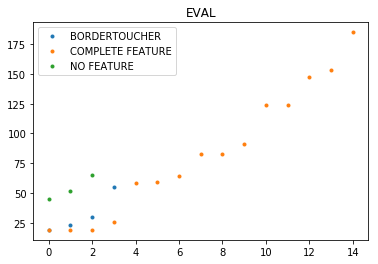

In [8]:
r = sorted_sums(ds_eval, m)
for k, v in r.items():
    label = label={v:k for k,v in ds.class_to_idx.items()}[k]
    plt.plot(v, ".", label=label)
plt.legend()
plt.title("EVAL")

In [9]:
def plot_activations(activations, normalize=True):
    
    max_rows = len(activations)
    max_cols = max(len(a) for a in activations.values())
    fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(20,5))
    for row, (label, images) in enumerate(activations.items()):
        print(label)
        for col, image in enumerate(images):
            axes[row, col].axis("off")
            if not normalize:
                axes[row, col].imshow(image, aspect="auto", vmin=0, vmax=1)
            else:
                axes[row, col].imshow(image, aspect="auto")
            
    plt.subplots_adjust(wspace=0.0, hspace=0.0)
    plt.show()    

def plot_matrix(ds, m, invert=False):
    activations = defaultdict(list)

    for img, cls in (ds[i] for i in range(len(ds))):
        label = get_label(ds, cls)
        x = img.unsqueeze(0).to(next(m.parameters()).device)
        y_mask = torch.sigmoid(m(x)).data.cpu().squeeze()
        if invert:
            y_mask = 1.0 - y_mask
        activations[label].append(y_mask)
        
    plot_activations(activations, normalize=False)

def plot_ds(ds):
    activations = defaultdict(list)

    for img, cls in (ds[i] for i in range(len(ds))):
        label = get_label(ds, cls)
        activations[label].append(torch.sigmoid(img).squeeze())
        max_rows = len(activations)
        
    plot_activations(activations, normalize=False)

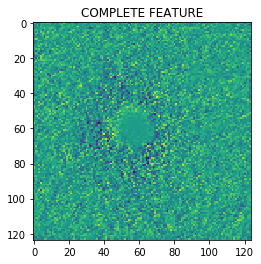

In [10]:
x, cls = ds_eval[7]
x = x.unsqueeze(0).to(next(m.parameters()).device)
label = get_label(ds, cls)

y_mask = torch.sigmoid(m(x)).data.cpu().squeeze(1)
#plot_pred(x.numpy().squeeze(), label+" INPUT")
plot_pred(y_mask[0].numpy(), label)

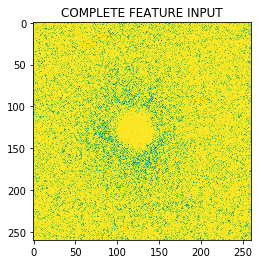

In [11]:
plot_pred(x.squeeze().data.cpu().numpy(), label+" INPUT")

In [12]:
def loss_hinge(result_sum, min_sum:float = 2000, max_sum:float = 6000):
    loss = F.relu(result_sum - max_sum) + \
           F.relu(-result_sum + min_sum)
    return loss

losses = []
for s in torch.linspace(0, 100, 100):
    losses.append(loss_hinge(s, 40, 80))

# TRAINING

In [13]:
from torch import optim
from torch.utils.data import DataLoader

def loss_hinge(result_sum, min_sum:float = 2000, max_sum:float = 6000):
    loss = F.relu(result_sum - max_sum) + \
           F.relu(-result_sum + min_sum)
    return loss

In [14]:
TRUTH_BOUNDS={"NO FEATURE":       (0, 50 // 4),
              "COMPLETE FEATURE": (1500 // 4, 5000 // 4),
              "BORDERTOUCHER":    (1500 // 4, 6000 // 4)}

In [80]:
def run_epoch(ds, m, optimizer, epoch_nr=0, num_workers=0, batch_size=4,
              debug_print=True, grad_print=True, debug_plot=True, train=True,
              TRUTH_BOUNDS={"NO FEATURE":       (0, 10//4),
                            "COMPLETE FEATURE": (2000 // 4, 8000 // 4),
                            "BORDERTOUCHER":    (1500 // 4, 4000 // 4)}):
    if train:
        m.train()
    else:
        m.eval()

    dl = DataLoader(ds)
    device = next(m.parameters()).device

    losses = []
    sums = defaultdict(list)  # How many pixels are active for each class

    for b, (imgs, classes) in enumerate(dl):
        
        imgs = imgs.to(device)
        
        if train:
            optimizer.zero_grad()
            preds = m(imgs)
        else:
            with torch.no_grad():
                preds = m(imgs)

        preds = torch.sigmoid(preds)
        labels = [get_label(ds, k.item()) for k in classes]
        truths = [TRUTH_BOUNDS[l] for l in labels]
        
        """"
        target = torch.tensor([(lower + upper) * 0.5 for lower,upper in truths],
                              requires_grad=False, device=device)
        
        single_loss = F.smooth_l1_loss(torch.sum(preds.view(imgs.shape[0], -1), dim=1), 
                                       target, reduction="none")
        loss = single_loss.sum() / target.sum()

        for pred, label in zip(preds, labels):
            s = pred.sum()
            sums[label].append(s.item())

        """
        single_losses = []
        for pred, _cls in zip(preds, classes):
            s = pred.sum()

            label = get_label(ds, _cls.item())
            lower, upper = TRUTH_BOUNDS[label]
            l = loss_hinge(s, lower, upper) #/ ((lower + upper) * 0.5)
            single_losses.append(l)
            sums[label].append(s.item())

        loss = sum(single_losses)
        """"""

        
        if train:
            loss.backward()
            if grad_print:
                grad_sum = 0.0
                for p in m.parameters():
                    grad_sum += (p.grad**2).sum().item()
                print("GRAD L2", grad_sum)

            optimizer.step()

        if debug_print:
            print(
                f"E[{epoch_nr}]-train {b}: {loss:.2f}, shapes: {[i.shape for i in imgs]}, labels: {labels}")

        losses.append(loss.item())

    if debug_plot:
        import matplotlib.pyplot as plt

        for label, v in sums.items():
            plt.plot(sorted(v), ".", label=label)
        plt.legend()
        plt.title("TRAIN" if train else "EVAL")

    return losses

In [81]:
###########################
m = SlimWide()
torchvision_default_initialize_weights(m)

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

m.to(device)

optimizer = torch.optim.SGD(m.parameters(), lr=1e-6, momentum=0.9, weight_decay=1e-4)
epoch_nr = 0

E[0] AVERAGE: 672.3205299806059
E[1] AVERAGE: 174.63933348923587
E[2] AVERAGE: 162.0259775740377
E[3] AVERAGE: 161.51939297793956
E[4] AVERAGE: 151.43354857369755
E[5] AVERAGE: 162.73650094364467
E[6] AVERAGE: 146.73985110507923
E[7] AVERAGE: 166.1916911093037
E[8] AVERAGE: 149.6368612225136
E[9] AVERAGE: 155.14695362562543
E[10] AVERAGE: 143.11327636375856
E[11] AVERAGE: 164.7221632539556
E[12] AVERAGE: 152.07041056772297
E[13] AVERAGE: 145.13514272282632
E[14] AVERAGE: 152.2084963509206
E[15] AVERAGE: 141.65464336952468
E[16] AVERAGE: 161.73856208029758
E[17] AVERAGE: 150.28293035271463
E[18] AVERAGE: 143.43705320894048
E[19] AVERAGE: 150.90073497643633
E[20] AVERAGE: 145.83818928579265
E[21] AVERAGE: 148.98728574259897
E[22] AVERAGE: 142.5860308529286
E[23] AVERAGE: 148.58934278166697
E[24] AVERAGE: 141.78605849019598
E[25] AVERAGE: 148.11494162913118
E[26] AVERAGE: 141.26280092389396
E[27] AVERAGE: 147.16600268074635
E[28] AVERAGE: 138.47042795245568
E[29] AVERAGE: 152.035004262174

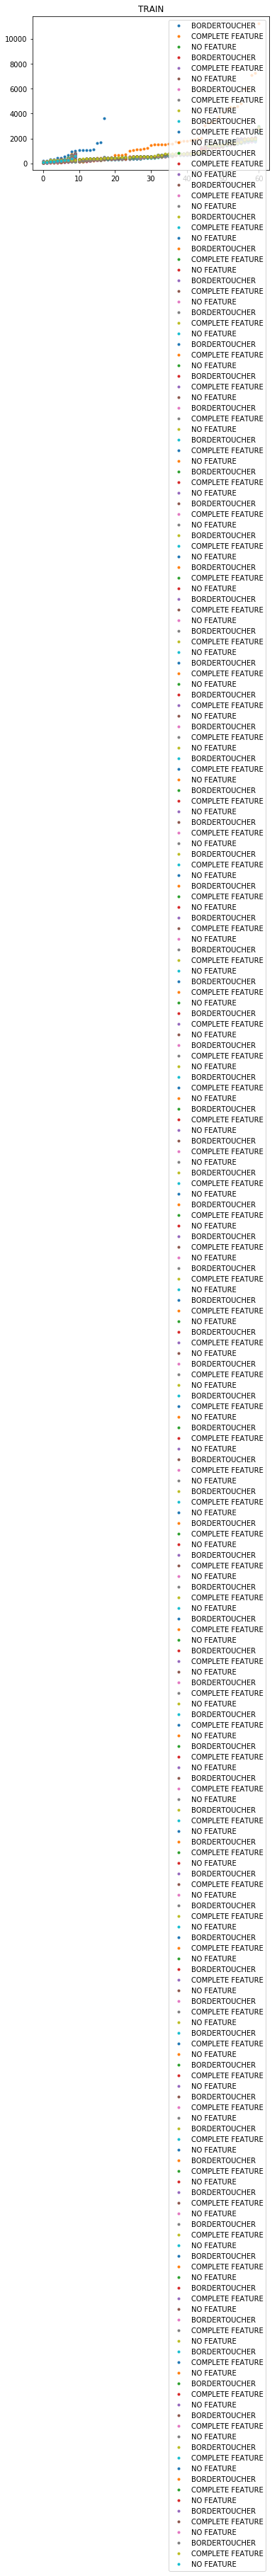

In [82]:
while epoch_nr < 80:
#if True:
    losses = run_epoch(ds_train, m, optimizer, epoch_nr=epoch_nr, train=True, 
                       debug_print=False, debug_plot=True, grad_print=False)
    print(f"E[{epoch_nr}] AVERAGE:", sum(losses)/len(losses))
    epoch_nr += 1

BORDERTOUCHER
COMPLETE FEATURE
NO FEATURE


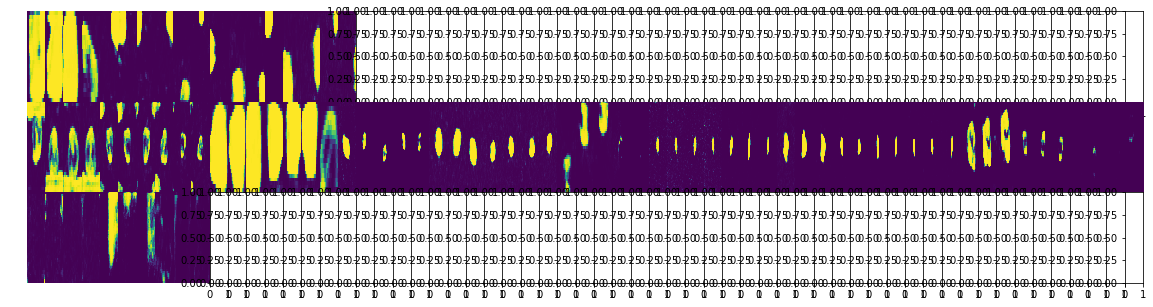

In [72]:
plot_matrix(ds_train, m)

BORDERTOUCHER
COMPLETE FEATURE
NO FEATURE


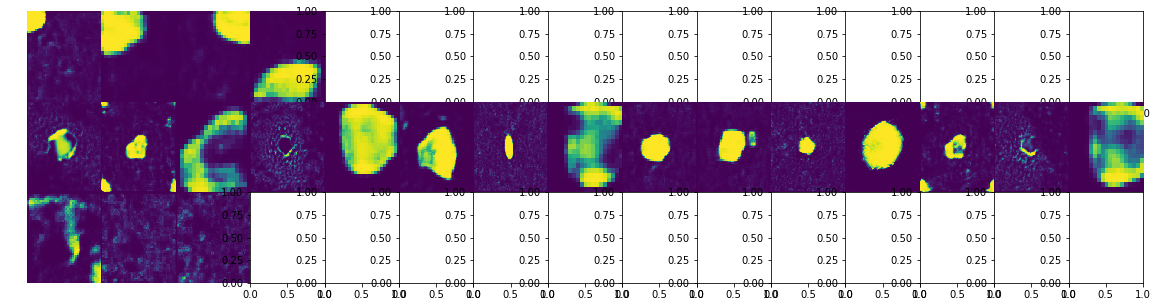

In [83]:
plot_matrix(ds_eval, m, invert=False)

BORDERTOUCHER
COMPLETE FEATURE
NO FEATURE


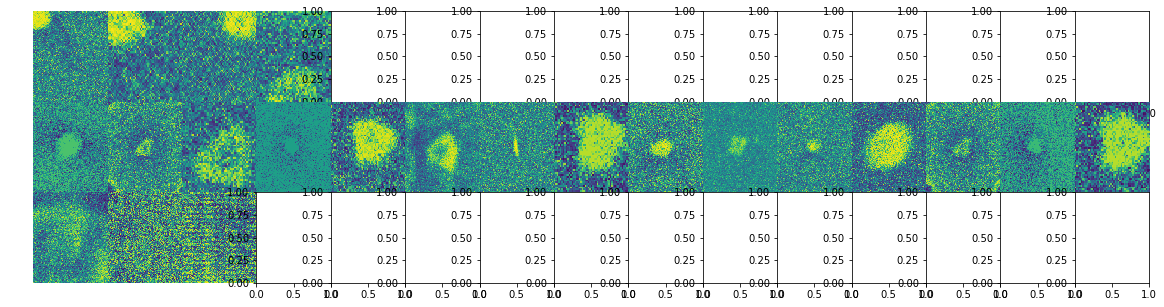

In [84]:
plot_ds(ds_eval)

E[80] AVERAGE: 513.3857902180065


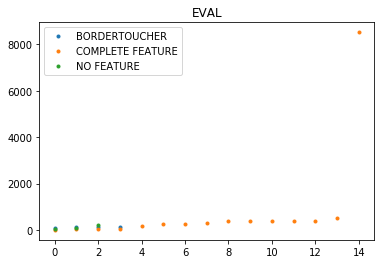

In [85]:
eval_losses = run_epoch(ds_eval, m, optimizer, epoch_nr=epoch_nr, train=False, debug_print=False)
print(f"E[{epoch_nr}] AVERAGE:", sum(eval_losses)/len(eval_losses))

E[80] AVERAGE: 197.04451000556517


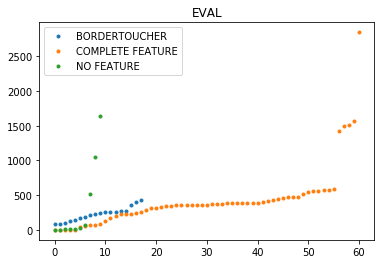

In [86]:
#while epoch_nr < 80:
if True:
    losses = run_epoch(ds_train, m, optimizer, epoch_nr=epoch_nr, train=False, 
                       debug_print=False, debug_plot=True, grad_print=False)
    print(f"E[{epoch_nr}] AVERAGE:", sum(losses)/len(losses))
    epoch_nr += 1